### A/334 Parameter Specification
- Autocorrection Delay = 3ms
- Sysmbol interval T = 1/106 seconds
- Marking Frequency Band = 2.5kHz - 5.0kHz

### Sample 
- frequency 48kHz -> 48000 frames/second
- Symbol frames 48000/106 = ca. 453 frames

### Help


In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, lfilter
from pydub import AudioSegment
import pandas as pd

In [2]:
audioSegment = AudioSegment.from_file("video.ts")
sig = np.frombuffer(audioSegment.raw_data, dtype='<i4').reshape(-1, audioSegment.channels)
samplerate = audioSegment.frame_rate
sig.shape

(14880384, 2)

In [3]:
offset_sec = 0.003
offset_frames = round(samplerate * offset_sec)
symbols_per_sec = 106
samples_per_symbol = samplerate / symbols_per_sec
samples_per_symbol

452.8301886792453

In [4]:
#https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [5]:
sig_bandpassed = butter_bandpass_filter(sig[:, 0], 2500, 5000, samplerate)

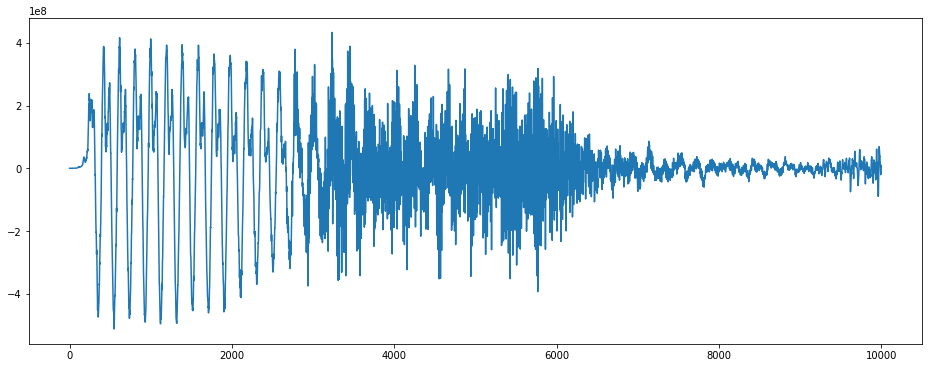

In [6]:
plt.figure(figsize=(16, 6))
plt.plot(sig[:10000, 0])

Time to run: 5.29 seconds


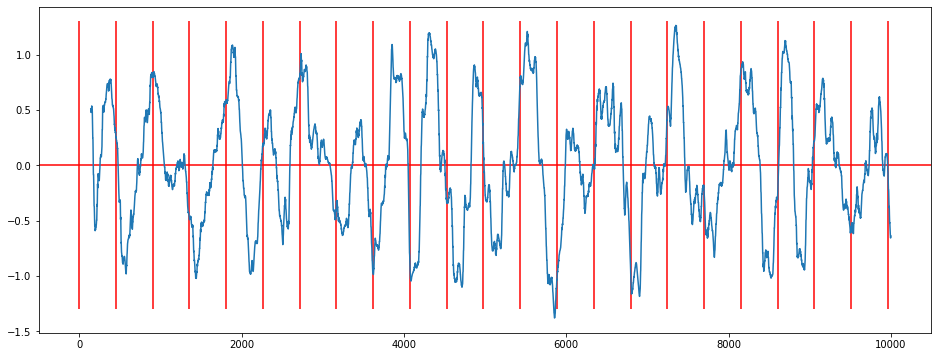

In [7]:
start_time = time.time()
sigg = sig_bandpassed

half_symbol = int(samples_per_symbol / 2)

df_first = pd.DataFrame(sigg[:-offset_frames - half_symbol])
df_first_2 = pd.DataFrame(sigg[half_symbol:-offset_frames])
df_delayed = pd.DataFrame(sigg[offset_frames: - half_symbol])
df_delayed_2 = pd.DataFrame(sigg[offset_frames + half_symbol:])

rolling_corr_1 = df_first.rolling(offset_frames).corr(df_delayed)
rolling_corr_2 = df_first_2.rolling(offset_frames).corr(df_delayed_2)

diffs = (rolling_corr_1 - rolling_corr_2).to_numpy()

plot_samples = 10000
plot_red_height = 1.3
plt.figure(figsize=(16, 6))
plt.vlines(np.arange(0, plot_samples, samples_per_symbol), -plot_red_height, plot_red_height, colors=["red"])
plt.axhline(y=0, color='r', linestyle='-')
plt.plot(diffs[:plot_samples], '-')
print(f"Time to run: {(time.time() - start_time):.2f} seconds")

In [8]:
MESSAGE_HEADER = '10101110000010101011100111100100'
for i in range(200000):
    is_correct = True
    for j in range(len(MESSAGE_HEADER)):
        if not (diffs[int(j * samples_per_symbol + i)] >= 0 and MESSAGE_HEADER[j] == '1' or diffs[
            int(j * samples_per_symbol + i)] < 0 and MESSAGE_HEADER[j] == '0'):
            is_correct = False
            break
    if is_correct:
        print(f"found offset for message start {i}")

found offset for message start 72016
found offset for message start 72017
found offset for message start 72018
found offset for message start 72019
found offset for message start 72020
found offset for message start 72021
found offset for message start 72022
found offset for message start 72023
found offset for message start 72024
found offset for message start 72025
found offset for message start 72026
found offset for message start 72027
found offset for message start 72028
found offset for message start 72029
found offset for message start 72030
found offset for message start 72031
found offset for message start 72032
found offset for message start 72033
found offset for message start 72034
found offset for message start 72035
found offset for message start 72036
found offset for message start 72037
found offset for message start 72038
found offset for message start 72039
found offset for message start 72040
found offset for message start 72041
found offset for message start 72042
f

should we choose the center value where it fits?

72016 + (72120 - 72016) / 2 = 72068 for the first one

I did not find anything about this in the spec

In [9]:
hmm = np.full((31800), False)
for i in range(hmm.shape[0]):
    hmm[i] = diffs[round(72068 + i * samples_per_symbol)] > 0
hmm2 = hmm.reshape((-1, 159))
hmm2

array([[ True, False,  True, ..., False, False,  True],
       [ True, False,  True, ..., False,  True,  True],
       [ True, False,  True, ..., False, False,  True],
       ...,
       [ True, False,  True, ..., False,  True,  True],
       [ True, False,  True, ..., False, False,  True],
       [ True, False,  True, ..., False,  True,  True]])

Header should be `AE0AB9E4`

In [10]:
bits = []
count = 0
err_count = 0

for i in range(hmm2.shape[0]):
    bits.append(np.packbits(hmm2[i, :]).tobytes())
    if (bits[i].hex().startswith("ae0ab9e4")):
        count += 1
    else:
        err_count += 1
    print(bits[i].hex())

ae0ab9e4021fadd8af4fdb047e750847885c0342
ae0ab9e45f4a4c6ae3087d33abfd0847885c0346
ae0ab9e468790cfb25f71f2118850847885c0342
ae0ab9a4e3e1cd0e7c87395c00ef08d7085c035e
ae2ab3e4ded28f9fa83a534eb3950847895c035a
ae0ab9e489876e2df1fdf579661d0847885c0356
ae0ab9e4bcb40ebc2540976bd5650847885c8342
ac0ab9e4f8b1804ac0f2eabad2350847885c032e
ae0ab9e4cd82c0d9844f88a8614d0847885c032a
ae0ab9e492d701e949882e9fb4c50847885c0326
ae0ab9e4a7ec41f88d354c8d07bd0847885c0322
be0ab9e4247c820dd20762f01fd50847885c133e
ae0ab9e4194fc29c16ba00e2acad0847885c0a3a
ae0ab9e4421a032a5b7fa6d579250847885c0336
ae0ab9e4732943bf9fc0c4c7ca5d0847885c0332
ae0ab9e4bdc544b45972dbdadadd0847885c030e
ae0ab9e489f604659defb9cc6ba50847885c030a
ae2ab9e4d7a3c597d0181ffbbe2d085f985e0306
ae0bfffee4d8850614b57de90d550847885c0302
ae0ab9e4690846f34b075394153518478858021e
ae0ab9e45e7b04628f3a3186a64508478f1c011a
ae0ab9e4036ec7d0c2fd97b173cd1847885c0312
2e0ab9e4365d87410640f5a3c0b50847885c0312
ae2ab9e48b65da3929996c137d6d0847885c03ee
a60ab9e4be569aac

In [11]:
print(f"correct: {count}, false: {err_count}, rate: {count / (count + err_count) * 100} %")

correct: 158, false: 42, rate: 79.0 %


## next step: BCH Code

p.37 of 64 in A/336

BCH (127, 50, 13)